## Testing

In [235]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats
import statsmodels.stats

In [236]:
data = pd.read_csv('C:\\Users\\juhic\\OneDrive\\Desktop\\master_dataset.csv')
data.drop(axis = 1, columns = 'Unnamed: 0', inplace = True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34138 entries, 0 to 34137
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   book_id                 34138 non-null  int64  
 1   book_name               34138 non-null  object 
 2   genre                   34138 non-null  object 
 3   page_count              34138 non-null  int64  
 4   is_volume               34138 non-null  object 
 5   rating_count            34138 non-null  int64  
 6   author_name             34138 non-null  object 
 7   author_sex              34138 non-null  object 
 8   author_work_count       34138 non-null  int64  
 9   author_fan_count        34138 non-null  int64  
 10  author_rating_count     34138 non-null  int64  
 11  author_review_count     34138 non-null  int64  
 12  author_avg_rating       34138 non-null  float64
 13  log2_author_work_count  34138 non-null  float64
 14  author_exp              34138 non-null

#### Type Conversions

In [237]:
data = data.astype({'is_volume':'category',
                    'author_sex':'category',
                    'author_exp':'category',
                    'book_size':'category',
                    'genre':'category',
                    'genre_category':'category'})
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34138 entries, 0 to 34137
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   book_id                 34138 non-null  int64   
 1   book_name               34138 non-null  object  
 2   genre                   34138 non-null  category
 3   page_count              34138 non-null  int64   
 4   is_volume               34138 non-null  category
 5   rating_count            34138 non-null  int64   
 6   author_name             34138 non-null  object  
 7   author_sex              34138 non-null  category
 8   author_work_count       34138 non-null  int64   
 9   author_fan_count        34138 non-null  int64   
 10  author_rating_count     34138 non-null  int64   
 11  author_review_count     34138 non-null  int64   
 12  author_avg_rating       34138 non-null  float64 
 13  log2_author_work_count  34138 non-null  float64 
 14  author_exp            

#### Hypothesis 1:

The publisher is interested to understand if the rating count between male & female authors is significantly different. If so, books from the group that holds larger rating counts would be prioritized over the other.

In [238]:
s0 = data[['author_name','author_sex']].drop_duplicates()
s1 = data.groupby(by = ['author_name'], as_index = False).agg({'rating_count':'mean'})
s2 = pd.merge(left = s0, right = s1, how = 'inner')
s2.head()

,author_name,author_sex,rating_count
0,kate brian,female,7199.000000
1,claudia gray,female,29449.700000
2,obert skye,male,12279.666667
3,meg cabot,female,26455.507937
4,john marsden,male,15747.100000


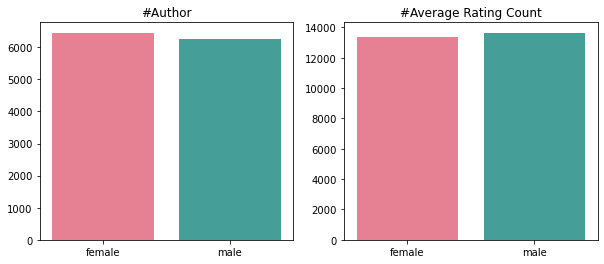

In [330]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (10,4))

sex = s2.groupby(by = 'author_sex', as_index = False).agg({'author_name':'count'})
sns.barplot(x = 'author_sex', y = 'author_name', data = sex, order = ['female','male'], palette = 'husl', ax = ax[0])
ax[0].set_title('#Author')
ax[0].set_ylabel('')
ax[0].set_xlabel('')


df_sex = s2.groupby(by = 'author_sex', as_index = False).agg({'rating_count':'mean'})
sns.barplot(x = 'author_sex', y = 'rating_count', data = df_sex, order = ['female','male'], palette = 'husl', ax = ax[1])
ax[1].set_title('#Average Rating Count')
ax[1].set_ylabel('')
ax[1].set_xlabel('')

plt.show()

**Hypothesis Test 1:**

<center> Null Hypothesis: Average rating counts b/w male & female authors are equal </center>
<center> $mean \space rating \space count_{male} = mean \space rating \space count_{female} $

Test:<br></br>
Independent 2-tailed Un-equal variance Z-test to compare mean reader count among the 2 groups.


Outcome:<br></br>
p-value of the sample under Null Hypothesis  <br></br>
Considering 5% level of significance,  if the p-value would be less than 5%, then we would reject the null hypothesis.

In [331]:
print("\n----- 2-tailed unequal variance Z test ------")

male = s2.loc[s2['author_sex'] == 'male','rating_count']
female = s2.loc[s2['author_sex'] == 'female','rating_count']

mean_diff = male.mean() - female.mean()
std_err = math.sqrt((male.var()/len(male)) + (female.var()/len(female)))

z_score = mean_diff / std_err
p_val = scipy.stats.norm.sf(abs(z_score))*2

print(f"\nusing formula")
print(f"test statistic: {z_score}, p-value:{p_val}")

print(f"\nusing built-in python function")

from statsmodels.stats import weightstats as ws
res1 = ws.ztest(x1 = male, x2 = female)
print(res1)


----- 2-tailed unequal variance Z test ------

using formula
test statistic: 0.2470395687517857, p-value:0.8048776014532185

using built-in python function
(0.24638958656882956, 0.805380666531034)


**Conclusion:**

p value > 0.05 <br></br>

We do not have enough evidence to reject the Null Hypothesis that the average rating count b/w men and women authors are equal.

#### Hypothesis 2

The publisher is interested to know if new-comer authors (published < 16 books) have a similar rating count as an average author (published average #books). This is to help avoid the new-comer trap! (when a publisher discards the book solely reasoning that the author has no experience) <br></br>
Work_count provides the #works (books, articles, revisions etc) of an author. It can be classified into 3 bins: 
- New-comers: < 16 (< log 4)
- Average: 16 - 256 (log 4 - log 8)
- Legendary: > 256 (> log 7)

In [332]:
e0 = data[['author_name','author_exp','author_work_count','log2_author_work_count']].drop_duplicates()
e1 = data.groupby(by = ['author_name'], as_index = False).agg({'rating_count':'mean'})
e2 = pd.merge(left = e0, right = e1, how = 'inner')
e2.head()

,author_name,author_exp,author_work_count,log2_author_work_count,rating_count
0,kate brian,average,40,5.357552,7199.000000
1,claudia gray,average,44,5.491853,29449.700000
2,obert skye,average,33,5.087463,12279.666667
3,meg cabot,average,134,7.076816,26455.507937
4,john marsden,average,57,5.857981,15747.100000


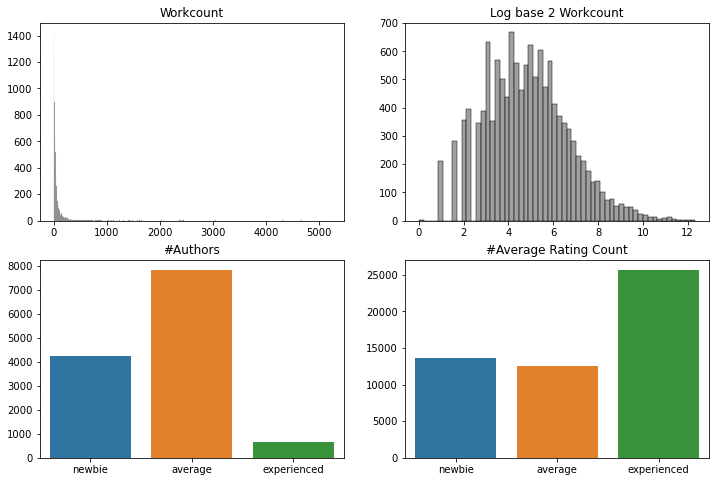

In [333]:
fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (12, 8))

sns.histplot(data = e2, x = 'author_work_count', color = 'grey', ax = ax[0,0])
ax[0,0].set_title('Workcount')
ax[0,0].set_xlabel('')
ax[0,0].set_ylabel('')

sns.histplot(data = e2, x = 'log2_author_work_count', color = 'grey', ax = ax[0,1])
ax[0,1].set_title('Log base 2 Workcount')
ax[0,1].set_xlabel('')
ax[0,1].set_ylabel('')

exp = e2.groupby(by = 'author_exp',as_index = False).agg({'author_name':'count'})
sns.barplot(x = 'author_exp', y = 'author_name', data = exp, order = ['newbie', 'average', 'experienced'], ax =  ax[1,0])
ax[1,0].set_title('#Authors')
ax[1,0].set_xlabel('')
ax[1,0].set_ylabel('')

df_exp = e2.groupby(by = 'author_exp', as_index = False).agg({'rating_count':'mean'})
sns.barplot(x = 'author_exp', y = 'rating_count', data = df_exp, order = ['newbie', 'average', 'experienced'], ax = ax[1,1])
ax[1,1].set_title('#Average Rating Count')
ax[1,1].set_ylabel('')
ax[1,1].set_xlabel('')

plt.show()

In [334]:
mean = e2['log2_author_work_count'].mean()
sd = np.std(e2['log2_author_work_count'])

print(f"Mean: {round(mean,4)} --> {round(pow(2, mean),0)}")
print(f"Standard Dev: {round(sd,4)}\n")
print(f"Newbie: {round(mean-sd,0)} --> {round(pow(2, mean-sd),0)}")
print(f"Average: {round(mean-sd,0), round(mean+sd,0)} --> {round(pow(2, mean-sd),0)}, {round(pow(2, mean+sd),0)}")
print(f"Experienced: {round(mean+1.5,0)} --> {round(pow(2, mean+sd),0)}")

Mean: 4.8256 --> 28.0
Standard Dev: 1.8514

Newbie: 3.0 --> 8.0
Average: (3.0, 7.0) --> 8.0, 102.0
Experienced: 6.0 --> 102.0


**Hypothesis 2:**

<center> Null Hypothesis: Average rating count of all class of authors are equal. </center>
<center> $mean \space rating \space count_{newbie} = mean \space rating \space count_{average} = mean \space rating \space count_{experienced}$

Test: <br></br>
Independent 2-tailed Z-test to compare mean rating count b/w New-comers and Average authors.

Outcome: <br></br>
p-value of the sample under Null Hypothesis <br></br>
Considering 5% level of significance,  if the p-value would be less than 5%, then we would reject the null hypothesis.


In [335]:
print("\n----- ANOVA ------")

import statsmodels.api as sm
from statsmodels.formula.api import ols

model = ols('rating_count ~ author_exp', data = e2).fit()
aov_table = sm.stats.anova_lm(model, typ=1)
print(f"{aov_table}\n")


----- ANOVA ------
                 df        sum_sq       mean_sq          F        PR(>F)
author_exp      2.0  1.047332e+11  5.236659e+10  15.668831  1.597660e-07
Residual    12716.0  4.249797e+13  3.342086e+09        NaN           NaN



**Conclusion:** p value < 0.05. We have enough evidence to reject the null hypothesis of equality of mean rating count across the 3 classes of authors.

**Pairwise Independent Z-test**

In [336]:
from statsmodels.stats import weightstats as ws

print(f"\nusing built-in python function\n")
exp = ['newbie','average','experienced']
for i in range(len(exp)-1):
    for j in range(i+1, len(exp)):
        x = e2.loc[e2['author_exp'] == exp[i], 'rating_count']
        y = e2.loc[e2['author_exp'] == exp[j], 'rating_count']
        res = ws.ztest(x1 = x, x2 = y, value = 0, alternative = 'two-sided', usevar = 'pooled')
        print(f"Class {exp[i], exp[j]} --> {res}")


using built-in python function

Class ('newbie', 'average') --> (1.0160269164120097, 0.3096165691549341)
Class ('newbie', 'experienced') --> (-3.9916319366711117, 6.562016380587855e-05)
Class ('average', 'experienced') --> (-6.5526533241665295, 5.6523634314278905e-11)


**Conclusion:**

1. Newbie v/s Average: p value > 0.05 <br></br>
   We do not have enough evidence to reject the Null Hypothesis that the average rating count b/w newbie & average authors are equal.
   
2. Newbie v/s Average & Average v/s Experienced: p value < 0.05 <br></br>
    We reject the null hypothesis that rating count across these class of authors are equal. Meaning: Experienced authors have statistically significant higher rating counts.

### Combined Hypothesis: Impact of Author Sex & Experience on Rating Count

In [337]:
c1 = pd.merge(left = e2, right = s0, how = 'inner')
c1.head()

,author_name,author_exp,author_work_count,log2_author_work_count,rating_count,author_sex
0,kate brian,average,40,5.357552,7199.000000,female
1,claudia gray,average,44,5.491853,29449.700000,female
2,obert skye,average,33,5.087463,12279.666667,male
3,meg cabot,average,134,7.076816,26455.507937,female
4,john marsden,average,57,5.857981,15747.100000,male


#### Check the author class behaviour across sex:

In [338]:
for i in c1['author_sex'].unique():
    if i == 'male':
        print(f"\nMALE")
    else:
        print(f"\nFEMALE")
        
    groups = c1['author_exp'].unique()
    for i in range(0, len(groups)-1):
        for j in range(i+1, len(groups)):
            res = ws.ztest(x1 = c1.loc[c1['author_exp'] == groups[i], 'rating_count'],
                           x2 = c1.loc[c1['author_exp'] == groups[j], 'rating_count'],
                           usevar = 'pooled', alternative = "two-sided")
            print("Class", (groups[i], groups[j]), res)


FEMALE
Class ('average', 'newbie') (-1.0160269164120097, 0.3096165691549341)
Class ('average', 'experienced') (-6.5526533241665295, 5.6523634314278905e-11)
Class ('newbie', 'experienced') (-3.9916319366711117, 6.562016380587855e-05)

MALE
Class ('average', 'newbie') (-1.0160269164120097, 0.3096165691549341)
Class ('average', 'experienced') (-6.5526533241665295, 5.6523634314278905e-11)
Class ('newbie', 'experienced') (-3.9916319366711117, 6.562016380587855e-05)


#### Check the male v/s female author behaviour across author class

In [339]:
for i in c1['author_exp'].unique():
    if i == 'newbie':
        print(f"\nNEWBIE")
    elif i == 'average':
        print(f"\nAVERAGE")
    else:
        print(f"\nEXPERIENCED")
        
    groups = c1['author_sex'].unique()
    for i in range(0, len(groups)-1):
        for j in range(i+1, len(groups)):
            res = ws.ztest(x1 = c1.loc[c1['author_sex'] == groups[i], 'rating_count'],
                           x2 = c1.loc[c1['author_sex'] == groups[j], 'rating_count'],
                           usevar = 'pooled', alternative = "two-sided")
            print("Class", (groups[i], groups[j]), res)


AVERAGE
Class ('female', 'male') (-0.24638958656882956, 0.805380666531034)

NEWBIE
Class ('female', 'male') (-0.24638958656882956, 0.805380666531034)

EXPERIENCED
Class ('female', 'male') (-0.24638958656882956, 0.805380666531034)


**Conclusion**: From the two tests above: behaviour is consistent. There is no effect of author sex on work experience and vice versa!

**Hypothesis 3:**

The publisher receives books with pages ranging from 1-10K+! Bulky books require a lot of time to be reviewed. And if they do not sell more, it’s just a waste of effort. The publisher is interested to see if the bulkier books have less rating count on an average as compared to average-sized books.  <br></br>
Books can be classified into 3 bins: <br></br>
- Light: < 200 pages
- Average: 200 - 400 pages
- Bulky: > 400 pages

In [340]:
p0 = data[['book_name','page_count','book_size','rating_count']]
p0.head()

,book_name,page_count,book_size,rating_count
0,inner circle,220,average,7597
1,ambition,279,average,6719
2,revelation,249,average,7431
3,legacy,243,average,7010
4,vanished,204,average,3724


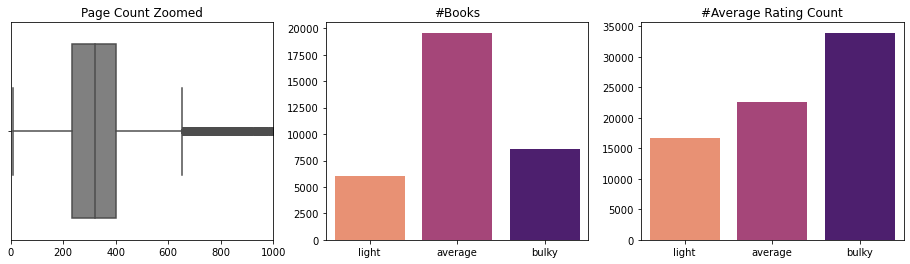

In [344]:
fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (16, 4))

sns.boxplot(x = 'page_count', data = p0, ax = ax[0], color = 'grey')
ax[0].set_title('Page Count Zoomed')
ax[0].set_xlim(0, 1000)
ax[0].set_xlabel('')

size = p0.groupby(by = 'book_size',as_index = False).agg({'book_name':'count'})
sns.barplot(x = 'book_size', y = 'book_name', data = size, order = ['light', 'average', 'bulky'], palette = 'magma_r', ax =  ax[1])
ax[1].set_title('#Books')
ax[1].set_ylabel('')
ax[1].set_xlabel('')

df_size = p0.groupby(by = 'book_size', as_index = False).agg({'rating_count':'mean'})
sns.barplot(x = 'book_size', y = 'rating_count', data = df_size, order = ['light', 'average', 'bulky'], palette = 'magma_r', ax = ax[2])
ax[2].set_title('#Average Rating Count')
ax[2].set_ylabel('')
ax[2].set_xlabel('')

plt.show()

**Hypothsis 3:**

<center> Null Hypothesis: Average rating count of of sized bookes are equal. </center>

Test: <br></br>
Independent 2-tailed Z-test to compare mean rating count b/w all 3 class of books.

Outcome: <br></br>
p-value of the sample under Null Hypothesis <br></br>
Considering 5% level of significance,  if the p-value would be less than 5%, then we would reject the null hypothesis. 


In [345]:
print("\n----- ANOVA ------")

import statsmodels.api as sm
from statsmodels.formula.api import ols

model = ols('rating_count ~ book_size', data = p0).fit()
aov_table = sm.stats.anova_lm(model, typ=1)
print(f"{aov_table}\n")


----- ANOVA ------
                df        sum_sq       mean_sq        F        PR(>F)
book_size      2.0  1.198054e+12  5.990268e+11  32.1299  1.146250e-14
Residual   34135.0  6.364097e+14  1.864391e+10      NaN           NaN



**Conclusion:** p value < 0.05. We have enough evidence to reject the null hypothesis of equality of mean rating count across the 3 sizes of books.

**Pairwise Independent Z-test**

In [346]:
print(f"\nusing built-in python function\n")
size = ['light','average','bulky']
for i in range(len(size)-1):
    for j in range(i+1, len(size)):
        x = p0.loc[p0['book_size'] == size[i], 'rating_count']
        y = p0.loc[p0['book_size'] == size[j], 'rating_count']
        res = ws.ztest(x1 = x, x2 = y, value = 0, alternative = 'two-sided', usevar = 'pooled')
        print(f"Class {size[i], size[j]} --> {res}")


using built-in python function

Class ('light', 'average') --> (-3.1090357422401165, 0.0018769901035332903)
Class ('light', 'bulky') --> (-7.643748478516759, 2.1098737046341615e-14)
Class ('average', 'bulky') --> (-6.046462467727214, 1.48060703715127e-09)


**Conclusion:**
All: Light v/s Average v/s Bulky: p value < 0.05 <br></br>
    We reject the null hypothesis that rating count across these class of books are equal. 
    Meaning: Bulky books have statistically significant higher rating counts.

#### Hypothesis 4:

Genre of the book is an obvious factor that can have a grossing affect on the rating count. The most popular ones being: Fiction and Non-Fiction (we’ll club the rest in ‘others’). Intuitively, most people prefer reading fiction over non-fiction and others. The publisher is interested to know if this is indeed true. If we find out that the rating count of fiction is not greater than non-fiction (or others), then we would know that the bias a publisher has toward fiction books is ill-formed.

In [418]:
g0 = data[['book_name','genre','genre_category','rating_count']]
g0.head()

,book_name,genre,genre_category,rating_count
0,inner circle,young adult,fiction,7597
1,ambition,young adult,fiction,6719
2,revelation,young adult,fiction,7431
3,legacy,young adult,fiction,7010
4,vanished,young adult,fiction,3724


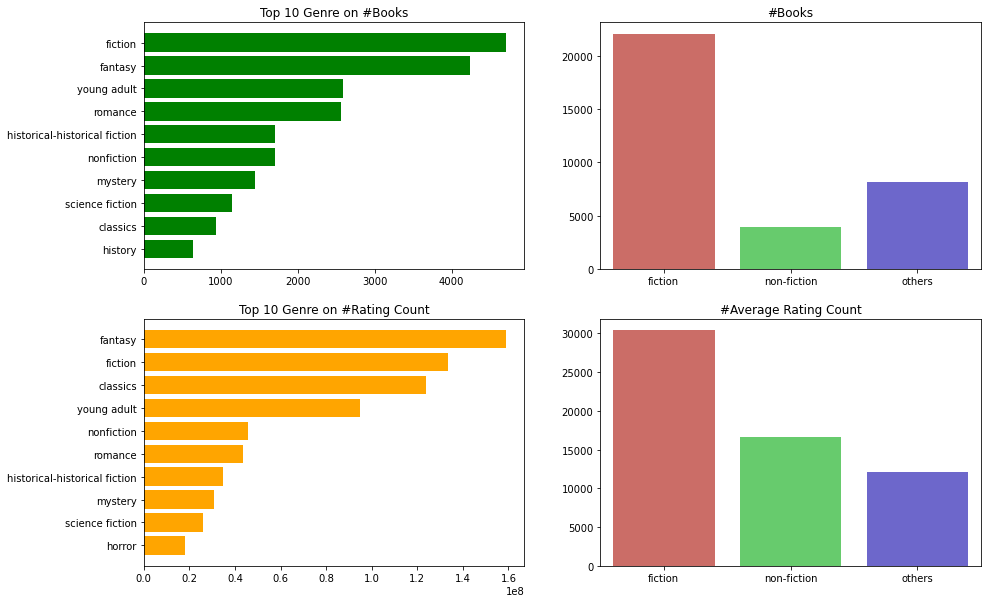

In [441]:
fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (15,10))

gx1 = pd.DataFrame(g0['genre'].value_counts()).reset_index()[0:10]
ax[0,0].barh(y = 'index', width = 'genre', data = gx1.sort_values(by = 'genre', ascending = True), color = 'green')
ax[0,0].set_title('Top 10 Genre on #Books')

gx2 = g0.groupby(by = 'genre',as_index = False).agg({'rating_count':'sum'}).sort_values(by = 'rating_count', ascending = False)[0:10]
ax[1,0].barh(y = 'genre', width = 'rating_count', data = gx2.sort_values(by = 'rating_count', ascending = True), color = 'orange')
ax[1,0].set_title('Top 10 Genre on #Rating Count')

genre = g0.groupby(by = 'genre_category',as_index = False).agg({'book_name':'count'})
sns.barplot(x = 'genre_category', y = 'book_name', data = genre, order = ['fiction', 'non-fiction', 'others'], palette = 'hls', ax =  ax[0,1])
ax[0,1].set_title('#Books')
ax[0,1].set_ylabel('')
ax[0,1].set_xlabel('')

df_genre = g0.groupby(by = 'genre_category', as_index = False).agg({'rating_count':'mean'})
sns.barplot(x = 'genre_category', y = 'rating_count', data = df_genre, order = ['fiction', 'non-fiction', 'others'], palette = 'hls', ax = ax[1,1])
ax[1,1].set_title('#Average Rating Count')
ax[1,1].set_ylabel('')
ax[1,1].set_xlabel('')


plt.show()

**Hypothesis 4:**

<center> Null Hypothesis: Average rating count of Fiction books is greater than or equal to that of non-fiction & others. </center>

Test: <br></br>
Pairwise comparison of means b/w group 1 v/s 2, and group 1 v/s 3
	
Outcome: <br></br>
p-value of the sample under Null Hypothesis in both tests <br></br>
Considering 5% level of significance,  if the p-value would be less than 5%, then we would reject the null hypothesis. 


In [442]:
print(f"\nusing built-in python function\n")
gen = ['fiction','non-fiction','others']
for i in range(len(gen)-1):
    for j in range(i+1, len(gen)):
        x = g0.loc[g0['genre_category'] == gen[i], 'rating_count']
        y = g0.loc[g0['genre_category'] == gen[j], 'rating_count']
        res = ws.ztest(x1 = x, x2 = y, value = 0, alternative = 'two-sided')
        print(f"Class {gen[i], gen[j]} --> {res}")


using built-in python function

Class ('fiction', 'non-fiction') --> (5.138707626988176, 2.76634422894546e-07)
Class ('fiction', 'others') --> (9.841139078088977, 7.485842469310643e-23)
Class ('non-fiction', 'others') --> (4.597470935849239, 4.276502608905288e-06)


### Combined Hypothesis: Impact of Book Size on Genre & vice-versa

In [450]:
c2 = pd.merge(left = g0, right = p0[['book_name','book_size']], how = 'inner', on = 'book_name')
c2.head()

,book_name,genre,genre_category,rating_count,book_size
0,inner circle,young adult,fiction,7597,average
1,ambition,young adult,fiction,6719,average
2,revelation,young adult,fiction,7431,average
3,revelation,young adult,fiction,7431,bulky
4,revelation,young adult,fiction,7431,average


#### Check Book Size behaviour across genre

In [452]:
sec1 = ['fiction','non-fiction','others']
for i in sec1:
    if i == 'fiction':
        print(f"\nFICTION")
    elif i == 'non-fiction':
        print(f"\nNON-FICTION")
    else:
        print(f"\nOTHERS")
        
    groups = ['light','average','bulky']
    for i in range(0, len(groups)-1):
        for j in range(i+1, len(groups)):
            res = ws.ztest(x1 = c2.loc[c2['book_size'] == groups[i], 'rating_count'],
                           x2 = c2.loc[c2['book_size'] == groups[j], 'rating_count'],
                           alternative = "two-sided")
            print("Class", (groups[i], groups[j]), res)


FICTION
Class ('light', 'average') (-2.879688144992288, 0.003980687045124031)
Class ('light', 'bulky') (-7.001605823033686, 2.5304518831628734e-12)
Class ('average', 'bulky') (-5.4367140797369045, 5.4272122282770015e-08)

NON-FICTION
Class ('light', 'average') (-2.879688144992288, 0.003980687045124031)
Class ('light', 'bulky') (-7.001605823033686, 2.5304518831628734e-12)
Class ('average', 'bulky') (-5.4367140797369045, 5.4272122282770015e-08)

OTHERS
Class ('light', 'average') (-2.879688144992288, 0.003980687045124031)
Class ('light', 'bulky') (-7.001605823033686, 2.5304518831628734e-12)
Class ('average', 'bulky') (-5.4367140797369045, 5.4272122282770015e-08)


#### Check Genre behaviour across size

In [455]:
sec1 = ['light','average','bulky']
for i in sec1:
    if i == 'light':
        print(f"\nLIGHT")
    elif i == 'average':
        print(f"\nAVERAGE")
    else:
        print(f"\nBULKY")
        
    groups = ['fiction','non-fiction','others']
    for i in range(0, len(groups)-1):
        for j in range(i+1, len(groups)):
            res = ws.ztest(x1 = c2.loc[c2['genre_category'] == groups[i], 'rating_count'],
                           x2 = c2.loc[c2['genre_category'] == groups[j], 'rating_count'],
                           alternative = "two-sided")
            print("Class", (groups[i], groups[j]), res)


LIGHT
Class ('fiction', 'non-fiction') (5.22884161956799, 1.7057541010684223e-07)
Class ('fiction', 'others') (10.861679473477887, 1.754915929025108e-27)
Class ('non-fiction', 'others') (5.788175205564558, 7.11551727471487e-09)

AVERAGE
Class ('fiction', 'non-fiction') (5.22884161956799, 1.7057541010684223e-07)
Class ('fiction', 'others') (10.861679473477887, 1.754915929025108e-27)
Class ('non-fiction', 'others') (5.788175205564558, 7.11551727471487e-09)

BULKY
Class ('fiction', 'non-fiction') (5.22884161956799, 1.7057541010684223e-07)
Class ('fiction', 'others') (10.861679473477887, 1.754915929025108e-27)
Class ('non-fiction', 'others') (5.788175205564558, 7.11551727471487e-09)
